In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.distribution_analysis.process_tree import get_observed_nodes

import seaborn as sns
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df
from src.datasets.load_trees import load_trees, TreeDataset, load_trees_from_file
from src.utils.tree_utils import get_taxa_names

import pandas as pd
from tqdm import tqdm

from src.distribution_analysis.clade import ObservedCladeSplit

In [2]:
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [3]:
DATA_SET = TreeDataset.YULE_10
DATA_SET_NAME = DATA_SET.value

### Load trees

In [4]:
trees = load_trees_from_file("/Users/tobiaochsner/Documents/Thesis/Validation/data/beast/yule-10-0.trees")

In [5]:
taxa_names = get_taxa_names(trees[0])
observed_nodes, observed_clade_splits = get_observed_nodes(trees, taxa_names)
df_clade_splits = get_clade_split_df(observed_clade_splits)

In [6]:
len(observed_clade_splits)

315009

### Analyze clade split heights

In [7]:
df_clade_splits["height"].describe()

count    315009.000000
mean          0.033996
std           0.023958
min           0.000000
25%           0.012681
50%           0.033055
75%           0.054359
max           0.127955
Name: height, dtype: float64

In [8]:
%%script true

grid = sns.FacetGrid(df_clade_splits, col="clade_split", col_wrap=8, height=2)
grid.map(sns.histplot, "height", kde=True, stat="density")

### Analyze observed branch lengths

In [9]:
df_clade_splits["min_branch"].describe()

count    3.150090e+05
mean     1.068820e-02
std      1.222035e-02
min      2.923678e-08
25%      2.242390e-03
50%      5.735506e-03
75%      1.333832e-02
max      8.867450e-02
Name: min_branch, dtype: float64

<Axes: xlabel='left_branch', ylabel='right_branch'>

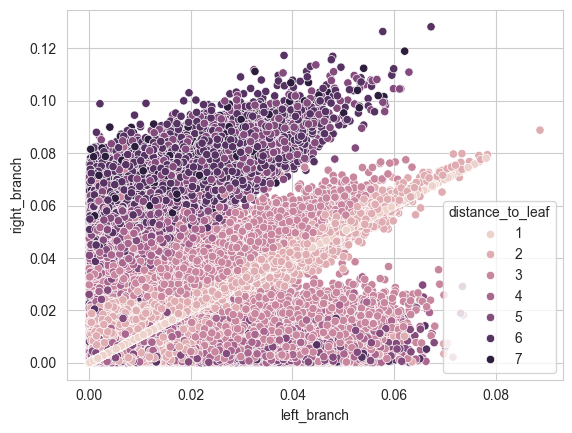

In [10]:
sns.scatterplot(data=df_clade_splits, x="left_branch", y="right_branch", hue="distance_to_leaf")

### Analyze branch lengths per clade split

The following analyses are performed on a per-clade-split basis and then averaged over all clade splits. This is important: if we don't condition on a clade split being present, we get wrong correlations (we then just observe that the entire tree scales due to shared rates).

Text(0.5, 1.0, 'Branch length correlation by distance to leaf (Yule-10)')

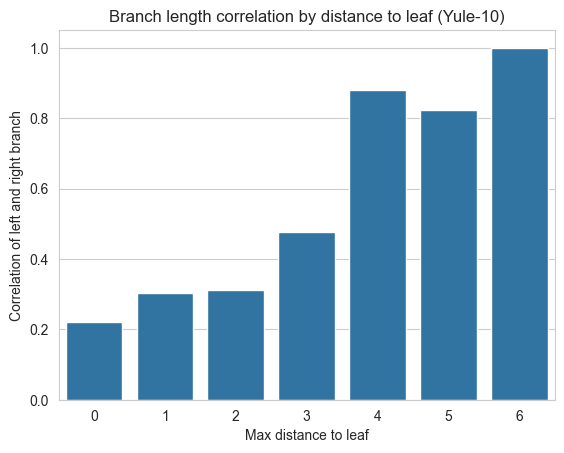

In [62]:
avg_correlation_per_level = df_clade_splits.groupby("distance_to_root").apply(
    lambda y: y.groupby("clade_split")
    .apply(lambda x: x["left_branch"].corr(y["right_branch"]))
    .mean()
)
sns.barplot(data=avg_correlation_per_level)

plt.ylabel("Correlation of left and right branch")
plt.xlabel("Max distance to leaf")

plt.title(f"Branch length correlation by distance to leaf ({DATA_SET_NAME})")

In [69]:
df_dict = {
    "clade_split": [],
    "min_branch_0": [],
    "min_branch_1": [],
    "min_branch_1_l+r": [],
    "distance_to_root": [],
    "distance_to_leaf": [],
    "min_distance_to_exit": [],
}

for clade_split in tqdm(observed_clade_splits):
    min_branch_0 = clade_split.min_branch_length

    min_branch_1 = None
    min_branch_1_lr = None
    min_branch_2 = None

    if isinstance(clade_split.min_branch_clade, ObservedCladeSplit):
        min_branch_1 = clade_split.min_branch_clade.min_branch_length

        if isinstance(clade_split.min_branch_clade.min_branch_clade, ObservedCladeSplit):
            min_branch_2 = clade_split.min_branch_clade.min_branch_clade.min_branch_length

    if isinstance(clade_split.left_clade, ObservedCladeSplit) and isinstance(clade_split.right_clade, ObservedCladeSplit):
        min_branch_1_lr = clade_split.left_clade.min_branch_length + clade_split.right_clade.min_branch_length

    df_dict["clade_split"].append(clade_split.bitstring)
    df_dict["min_branch_0"].append(min_branch_0)
    df_dict["min_branch_1"].append(min_branch_1)
    df_dict["min_branch_1_l+r"].append(min_branch_1_lr)
    df_dict["distance_to_root"].append(clade_split.distance_to_root)
    df_dict["distance_to_leaf"].append(clade_split.distance_to_leaf)
    df_dict["min_distance_to_exit"].append(min(clade_split.distance_to_root, clade_split.distance_to_leaf))

df_extended_branches = pd.DataFrame(df_dict)

100%|██████████| 315009/315009 [00:00<00:00, 765095.55it/s]


<Axes: >

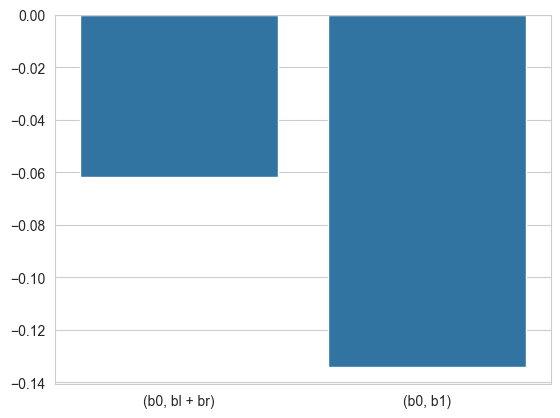

In [70]:
import numpy as np


sns.barplot(
    x=["(b0, bl + br)", "(b0, b1)"],
    y=[
        df_extended_branches.groupby("clade_split")
        .apply(lambda x: x["min_branch_0"].map(np.log).cov(x["min_branch_1"].map(np.log)))
        .mean(),
        df_extended_branches.groupby("clade_split")
        .apply(lambda x: x["min_branch_0"].corr(x["min_branch_1"]))
        .mean(),
    ],
)

Text(0.5, 0, 'Correlation between minimum branch lengths')

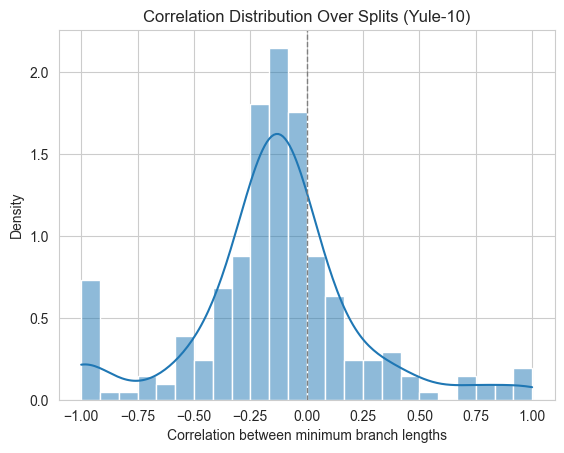

In [71]:
sns.histplot(
    df_extended_branches.groupby("clade_split").apply(
        lambda x: x["min_branch_0"].corr(x["min_branch_1"])
    ),
    stat="density",
    kde=True,
)
plt.axvline(x=0, linestyle='--',linewidth=1, color='grey')

plt.title(f"Correlation Distribution Over Splits ({DATA_SET_NAME})")
plt.xlabel("Correlation between minimum branch lengths")

Text(0.5, 1.0, 'Branch length correlation by distance to leaf (Yule-10)')

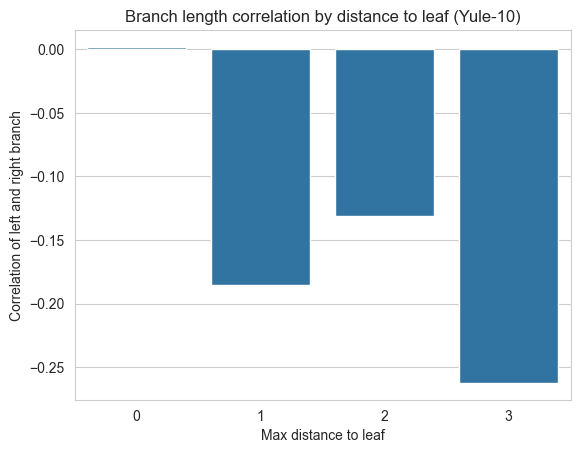

In [75]:
avg_correlation_per_level = df_extended_branches.groupby("min_distance_to_exit").apply(
    lambda y: y.groupby("clade_split")
    .apply(lambda x: x["min_branch_0"].corr(y["min_branch_1"]))
    .mean()
)
sns.barplot(data=avg_correlation_per_level)

plt.ylabel("Correlation of left and right branch")
plt.xlabel("Max distance to leaf")

plt.title(f"Branch length correlation by distance to leaf ({DATA_SET_NAME})")

In [57]:
corrs = df_extended_branches.groupby("clade_split").apply(
    lambda x: x["min_branch_0"].corr(x["min_branch_1"])
)
corrs.index[corrs == -1.0].map(lambda x: len(df_extended_branches[df_extended_branches.clade_split == x]))

Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype='int64', name='clade_split')

<Axes: xlabel='min_branch_1', ylabel='min_branch_0'>

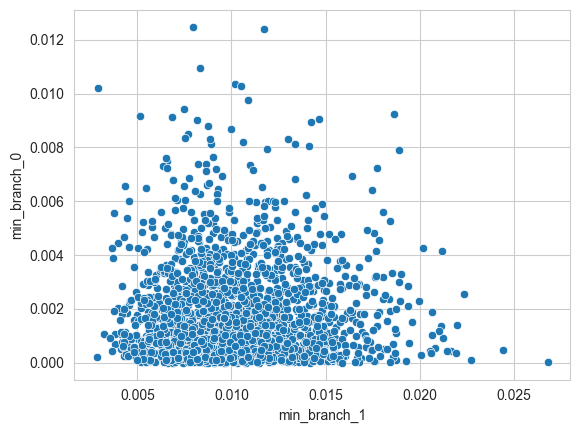

In [18]:
sns.scatterplot(
    x=df_extended_branches[df_extended_branches.clade_split == (3, 4)]["min_branch_1"],
    y=df_extended_branches[df_extended_branches.clade_split == (3, 4)]["min_branch_0"],
)

<Axes: xlabel='min_branch', ylabel='distance_to_root'>

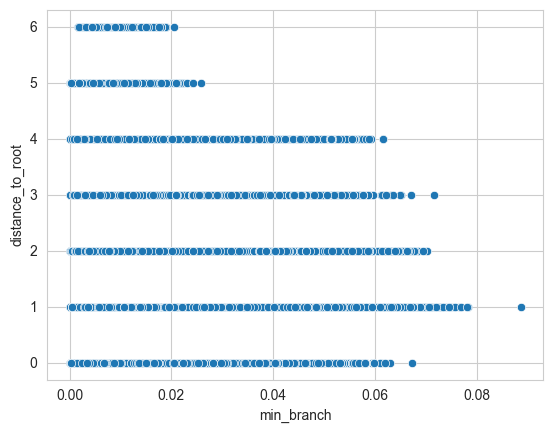

In [19]:
sns.scatterplot(
    x=df_clade_splits["min_branch"],
    y=df_clade_splits["distance_to_root"]
)

In [20]:
df_most_common_branches_splits = df_clade_splits[df_clade_splits.clade_split.isin(df_clade_splits.clade_split.value_counts().nlargest(16).index)]

Text(0.5, 0.98, 'Distribution of d_min per clade split (Yule-10)')

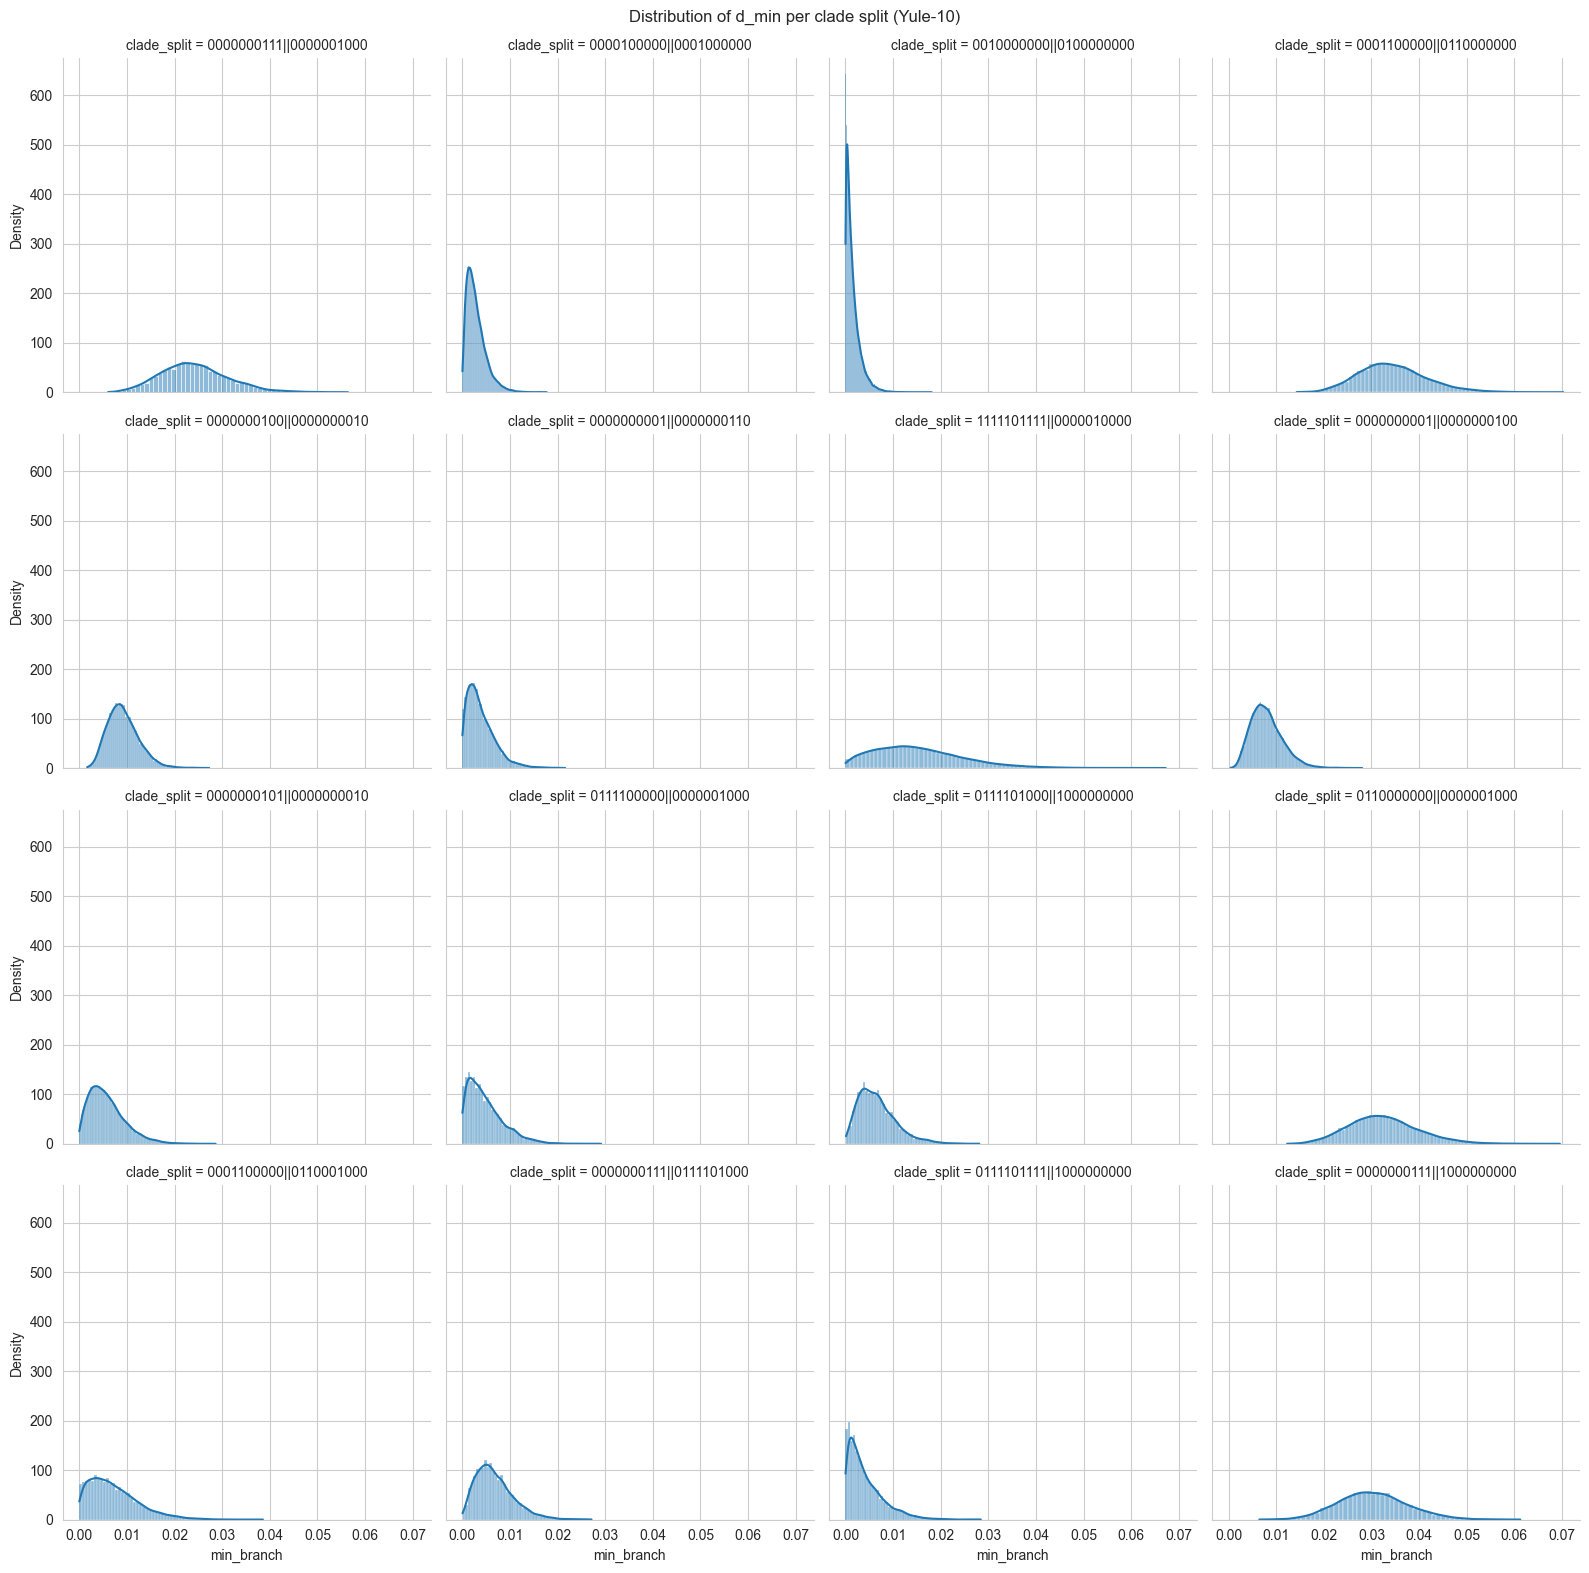

In [21]:
grid = sns.FacetGrid(df_most_common_branches_splits, col="clade_split", col_wrap=4, height=4)
grid.map(sns.histplot, "min_branch", kde=True, stat="density")

grid.figure.subplots_adjust(top=0.95)
grid.figure.suptitle(f"Distribution of d_min per clade split ({DATA_SET_NAME})")

In [22]:
df_extended_branches.describe()

,min_branch_0,min_branch_1,min_branch_1_l+r
count,3.150090e+05,2.071370e+05,72871.000000
mean,1.068820e-02,1.147637e-02,0.025900
std,1.222035e-02,1.285367e-02,0.019325
min,2.923678e-08,1.546821e-07,0.000047
25%,2.242390e-03,2.577938e-03,0.007770
50%,5.735506e-03,6.254668e-03,0.024993
75%,1.333832e-02,1.386881e-02,0.039468
max,8.867450e-02,8.867450e-02,0.117747
